In [1]:
from scipy.ndimage.filters import uniform_filter1d
import numpy as np
from scipy import signal
from scipy.io.wavfile import read
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

# %%
def load_wav(file, verbose=False):
    fs, x = read(file)
    x = np.transpose(x)
    x = x[1]

    # x /= np.max(np.abs(x))

    if verbose:
        print('Loading: ', file)
        print('fs:', fs)
        print('x.shape: ', x.shape)
        print('min: ', np.min(x))
        print('max: ', np.max(x))
    return x, fs


def get_num_zof_windows(len_audio, win_size, overlap):
    i = 0
    num_of_win = 0

    while i+win_size < len_audio:
        num_of_win += 1
        i += round(win_size-win_size*overlap)

    return num_of_win


# %%
def get_spectrum(file, win_size=2**8):
    x, fs = load_wav(file)

    win_type = 'hanning'
    window = signal.windows.hann(win_size)
    overlap = 0.5
    len_audio = x.shape[0]

    i = 0
    index = 0
    spls = []

    while i+win_size < len_audio:
        # Windowing the signal.
        start = i
        end = i+win_size
        x_w = x[start:end]
        if win_type != 'square':
            x_w *= window

        # Calculating the spectrum (rfft)
        yf = rfft(x_w)
        yf = 20*np.log10(abs(yf))
        xf = rfftfreq(win_size, 1 / fs)
        spls.append(yf)

        # Updating index
        index += 1
        i += round(win_size-win_size*overlap)

    # Apply mean to all of the SPLs
    return np.mean(spls, 0), xf



In [2]:
import os
base_uri = os.path.join("white_noise")
files = {
    "frontal": {
        "con-bola": os.path.join(base_uri, "frontal", "sin-bola.wav"),
        "sin-bola": os.path.join(base_uri, "frontal", "con-bola.wav")},
    "lateral": {
        "con-bola": os.path.join(base_uri, "lateral", "con-bola.wav"),
        "sin-bola": os.path.join(base_uri, "lateral", "sin-bola.wav"),
    }}


# Window size (for the fft)
win_size = 2**12
# runnign average w/ number of samples: N (for plotting)
N = 100

fr_con, freq = get_spectrum(files['frontal']['con-bola'], win_size)
fr_sin, _ = get_spectrum(files['frontal']['sin-bola'], win_size)
la_con, _ = get_spectrum(files['lateral']['con-bola'], win_size)
la_sin, _ = get_spectrum(files['lateral']['sin-bola'], win_size)


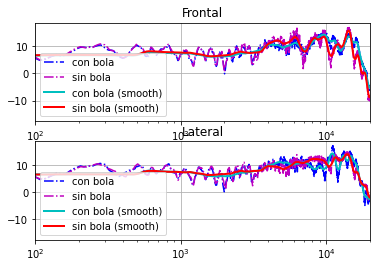

In [3]:
fig = plt.figure()

ax = fig.add_subplot(2, 1, 1)
ax.plot(freq, fr_con, 'b-.', label='con bola')
ax.plot(freq, fr_sin, 'm-.', label='sin bola')
fr_con_smoth = uniform_filter1d(fr_con, size=N)
ax.plot(freq, fr_con_smoth, 'c-', label='con bola (smooth)', linewidth=2)
fr_sin_smoth = uniform_filter1d(fr_sin, size=N)
ax.plot(freq, fr_sin_smoth, 'r-', label='sin bola (smooth)', linewidth=2)

ax.set_xscale('log')
ax.set_xlim([100, 20e3])
ax.legend()
ax.grid(True)
ax.set_title('Frontal')

ax = fig.add_subplot(2, 1, 2)
ax.plot(freq, la_con, 'b-.', label='con bola')
ax.plot(freq, la_sin, 'm-.', label='sin bola')
la_con_smoth = uniform_filter1d(la_con, size=N)
ax.plot(freq, la_con_smoth, 'c-', label='con bola (smooth)', linewidth=2)
la_sin_smoth = uniform_filter1d(la_sin, size=N)
ax.plot(freq, la_sin_smoth, 'r-', label='sin bola (smooth)', linewidth=2)

ax.set_xscale('log')
ax.set_xlim([100, 20e3])
ax.legend()
ax.grid(True)
ax.set_title('Lateral')

plt.show()
